# Introduction
A useful tool in science is the ability to fit a function to experimental data, in order to build a better understanding of the underlying system(s). More complex systems are often comprised of many related, and potentially unknown, nonlinear equations. This can make understanding the system very difficult. Being able to approximate these equations would allow you to predict future values, and has significant applications in many fields, among them, Engineering Control Systems, Finance, and weather prediction.

As it turns out, a Neural Network can be used as an approximation to an unknown system of nonlinear equations. A Neural Net is even capable of capturing the behaviour of a system, even if the underlying phenomenona governing aren't known! Below I explore using a MultiLayer Perception (MLP) Neural Network to fit a 'chirp' function of the form: A∗sin(w(t)∗t) 
, where w(t)=2∗pi∗t. This function is interesting because it is periodic, with a decreasing wavelength as it increases in time.

(This article is not intended to be an introduction tutorial on Tensorflow, or Neural Networks. It is assumed the reader is familiar with basic concepts of each.)
 

# Goal

The goal of this Notebook is to experiment with using a MLP Neural Network to model an unknown function. Data will be generated with the function, and noise will be added added. These noisy data points will then be partitoned into testing and training data for the network.

While the main goal of this is experimentation and learning, this technique may be useful in a case where a user has a data set governed by an unknown function. This technique can be used to model the unknown function, so it can be used on new data, or further analyzed.

This work is done in a Jupyter Notebook, using python 3.5 and Tensorflow 1.0.0

Full Notebook can be found [at my GitHub](https://github.com/hopperj/learning-tensorflow)

In [36]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from random import shuffle
from IPython import display
import os

In [22]:
training_epochs = 3500
display_step = training_epochs*0.1
epoch_plots = 0
num_examples = 5000
test_fraction = 0.75

#### Use a set seed to make things easily repeatable

In [23]:
np.random.seed(1000)

#### Neural Network size parameters

In [24]:
n_input = 1
hidden_nodes = 50
n_hidden_0 = hidden_nodes
n_hidden_1 = hidden_nodes
n_hidden_2 = hidden_nodes
n_hidden_3 = hidden_nodes
n_hidden_4 = hidden_nodes
n_hidden_5 = hidden_nodes
n_hidden_6 = hidden_nodes

num_of_hidden_layers = 7
n_output = n_input

### Test Functions

Return whatever you like from f(x). In place currently is a 'chirp' function of the form: 

$ A*sin(w(t)*t) $, where $ w(t) = 2*pi*t $

The chrip function is an interesting test because the oscillation frequency increases with time, making the NN require greater complexity to model. Less complicated function examples can be uncommented and used, however the network parameters should be adjusted accordingly.

In [25]:
def w(x):
    return 2.0*np.pi*x

def f(x):
#     return np.sin(x) + 0.1*np.random.randn(*x.shape)
#     return np.cos(x/np.pi)
#     return np.cos(x) + np.sin(x/np.pi)
    return np.sin( w(x)*x/1.5 )+ 0.1*np.random.randn(*x.shape)

### X data generation

Generate equally spaced x data and plot example function values

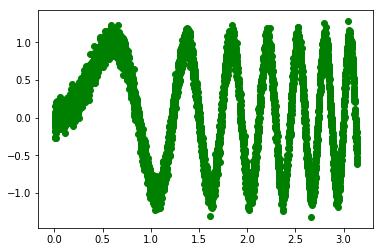

In [26]:
all_x = np.random.uniform(0*np.pi, np.pi, (1, num_examples)).T
plt.scatter(all_x, f(all_x), color='g')

### Training/Testing Set Creation

Create shuffled data. Split into training and testing sets based on the `test_fraction` value

In [27]:
np.random.shuffle(all_x)
train_size = int(num_examples*test_fraction)

# Partition data
x_training = all_x[:train_size]
x_testing = all_x[train_size:]
y_training = f(x_training)
y_testing = f(x_testing)

### Generated data plotting

Plot test and training data for visual inspection

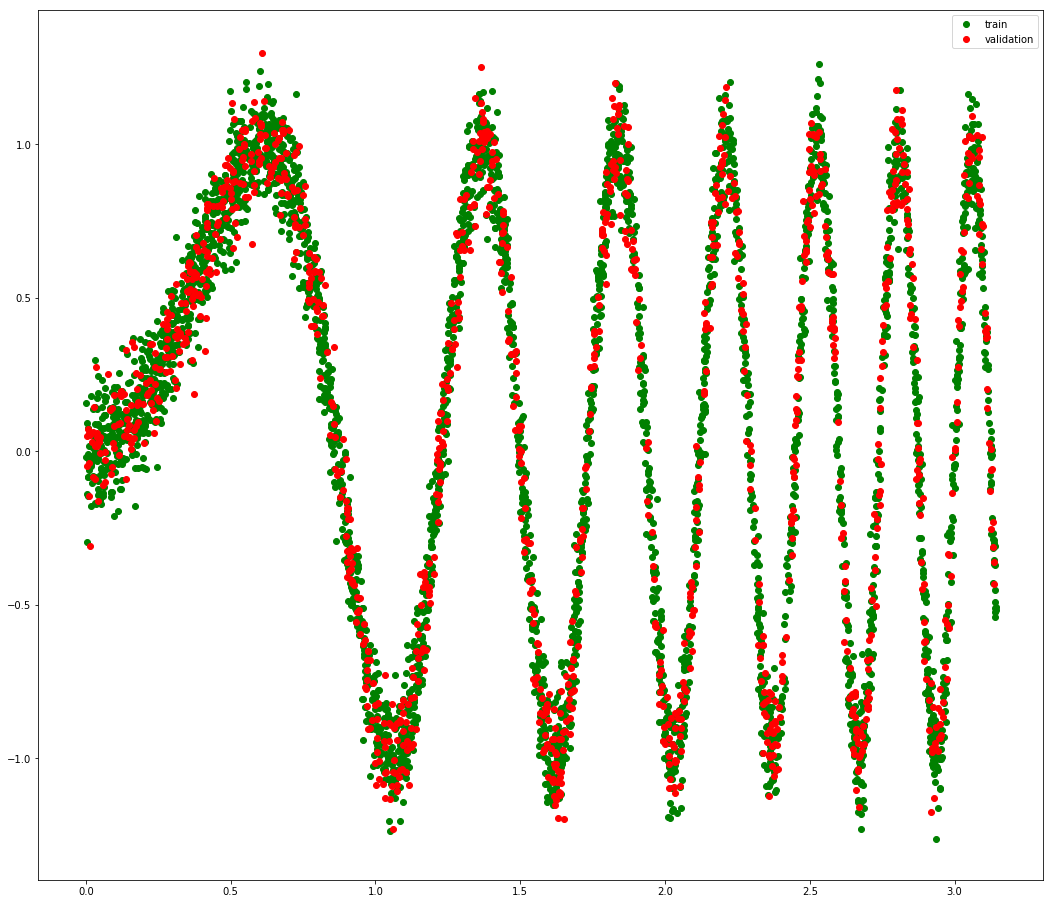

In [28]:
plt.figure(1, figsize=(18, 16))
plt.scatter(x_training, y_training, c='green', label='train')
plt.scatter(x_testing, y_testing, c='red', label='validation')
plt.legend()

In [29]:
tf.reset_default_graph()

### Graph Creation

Create a network with 7 hidden layers. This number is chosen only for example. Depending on the chosen f(x), additional or fewer layers may be needed. similarily the number of nodes in each layer can be tuned for specific choices of functions.

The NN function function takes an input tensor and number of hidden layers. It will then use the weight tensors defined in `weights`, and use biases defined in `biases`.

In [30]:
X = tf.placeholder("float", [None, n_input], name='X')
Y = tf.placeholder("float", [None, n_output], name='Y')


weights = {
    'h0': tf.Variable(tf.random_normal([n_input, n_hidden_0])),
    'h1': tf.Variable(tf.random_normal([n_hidden_0, n_hidden_1])),
    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
    'h3': tf.Variable(tf.random_normal([n_hidden_2, n_hidden_3])),
    'h4': tf.Variable(tf.random_normal([n_hidden_3, n_hidden_4])),
    'h5': tf.Variable(tf.random_normal([n_hidden_4, n_hidden_5])),
    'h6': tf.Variable(tf.random_normal([n_hidden_5, n_hidden_6])),
    'out': tf.Variable(tf.random_normal([n_hidden_6, n_output])),
}

biases = {
    'h0': tf.Variable(tf.random_normal([n_hidden_0])),
    'h1': tf.Variable(tf.random_normal([n_hidden_1])),
    'h2': tf.Variable(tf.random_normal([n_hidden_2])),
    'h3': tf.Variable(tf.random_normal([n_hidden_3])),
    'h4': tf.Variable(tf.random_normal([n_hidden_4])),
    'h5': tf.Variable(tf.random_normal([n_hidden_5])),
    'h6': tf.Variable(tf.random_normal([n_hidden_6])),
    'out': tf.Variable(tf.random_normal([n_output])),
}


def NN(input_layer, n):
    '''
        x: Input Tensor
        n: number of hidden layers to build
        
        Returns: output layer
        
        Builds a network starting with `input_layer`, containing n hidden
        layers, and returns `output` layer.
    '''
    def __build_hidden(inpt_layer, n):
        # Layer Number counter
        ln = 0
        layer = tf.nn.sigmoid(
                tf.add(
                    tf.matmul(
                        inpt_layer, weights['h%d'%(ln)],
                        name='layer%d'%(ln)
                    ),
                    biases['h%d'%(ln)]
                )
            )
        # Increment Layer Number
        ln += 1
        while ln < n:
            layer = tf.nn.sigmoid(
                tf.add(
                    tf.matmul(
                        layer, weights['h%d'%(ln)],
                        name='layer%d'%(ln)
                    ),
                    biases['h%d'%(ln)]
                )
            )
            ln += 1
        return layer        
    
    
    layer = __build_hidden(input_layer, n)
    
    output = tf.add(
                tf.matmul(
                    layer, weights['out'],
                    name="out"
                ),
                biases['out']
            )
    return output


### Network and Training Optimizer Initialization

Build Neural Network using `NN()` function. Create cost function, and link optimizer.

In [31]:
output = NN(X, num_of_hidden_layers)
cost = tf.reduce_mean(tf.pow(output - Y, 2))
optimizer = tf.train.AdamOptimizer().minimize(tf.nn.l2_loss(output - Y))

In [32]:
init = tf.global_variables_initializer()

In [33]:
sess = tf.InteractiveSession()

/Users/schwd/Programs/tensorflow/env/lib/python2.7/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


### Training

Train network on training set. Track network error on validation set as well as test set. At marked epoches, print the current cost, and plot the networks best ability to model the data. This plotting makes the training *much* slower. Modifying the `1==1` condition is an easy way to enable/disable it.

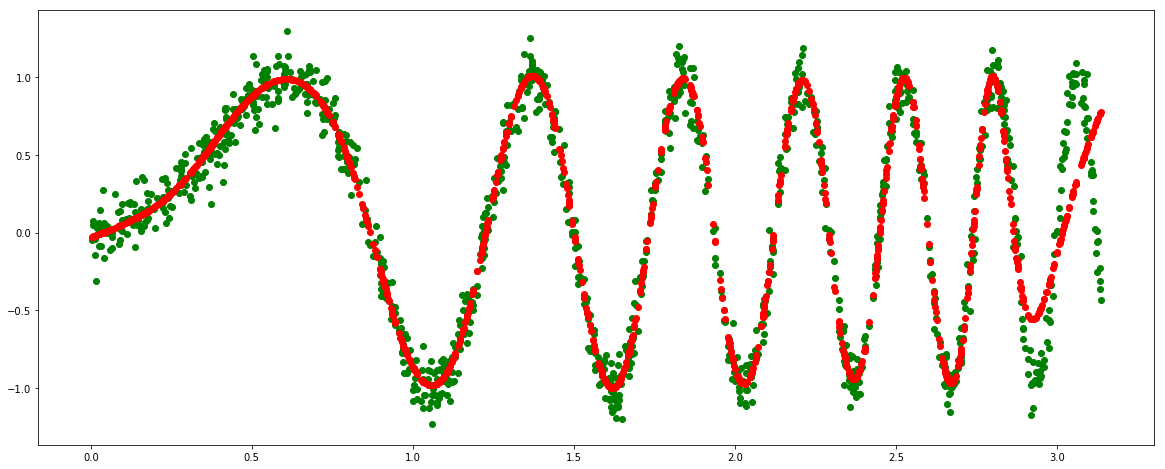

Epoch: 03500	MSE: 2.7813e-02
Training complete!


In [37]:
costs = []
epoches = []
total_error = []

# Add ops to save and restore all the variables
saver = tf.train.Saver()
if not os.path.exists('function_model'):
    os.makedirs('function_model')

sess.run(init)

for epoch in range(training_epochs):
    _, c = sess.run(
        [ optimizer, cost ],
        feed_dict={
            X:x_training,
            Y:y_training
        }
    )

    costs.append(c)
    epoches.append(epoch)
    
    mse = sess.run(tf.nn.l2_loss(output - y_testing),  feed_dict={X:x_testing})
    total_error.append(mse)
    
    if epoch%display_step == 0:
        print('Epoch: %05d\tCost: %.4e'%(epoch, c))

        if epoch_plots or True:
            fig = plt.figure(figsize=(20,8))
            plt.scatter( x_testing, y_testing, color='g')
            plt.scatter( x_testing, sess.run(output, feed_dict={X: x_testing}), color='r')
            display.display(plt.gcf())
            display.clear_output(wait=True)
            plt.show()
            # Uncomment the following line to save images
            fig.savefig("function_model/%4d_training_plot.jpg"%(epoch))

    
print('Epoch: %05d\tMSE: %.4e'%(epoch+1, c))
print('Training complete!')

# Save checkpoint, graph.pb and tensorboard
saver.save(sess, "function_model/model.ckpt") 
tf.train.write_graph(sess.graph.as_graph_def(), "function_model/", "graph.pb")
tf.summary.FileWriter("board", sess.graph)


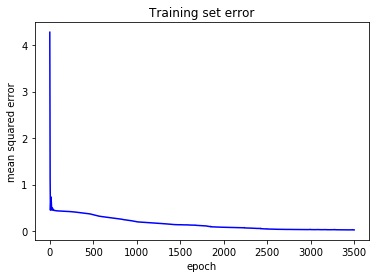

In [38]:
plt.plot( epoches, costs, 'b' )
plt.title('Training set error')
plt.xlabel('epoch')
plt.ylabel('mean squared error')
plt.show()

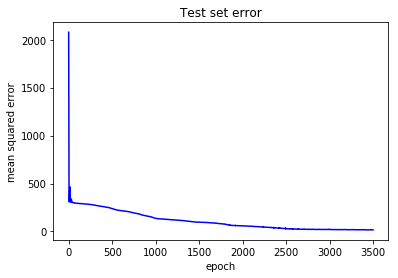

In [39]:
plt.plot( epoches, total_error, 'b' )
plt.title('Test set error')
plt.xlabel('epoch')
plt.ylabel('mean squared error')
plt.show()

### Model Prediction

Plot the model across all data, overalyed with original data.

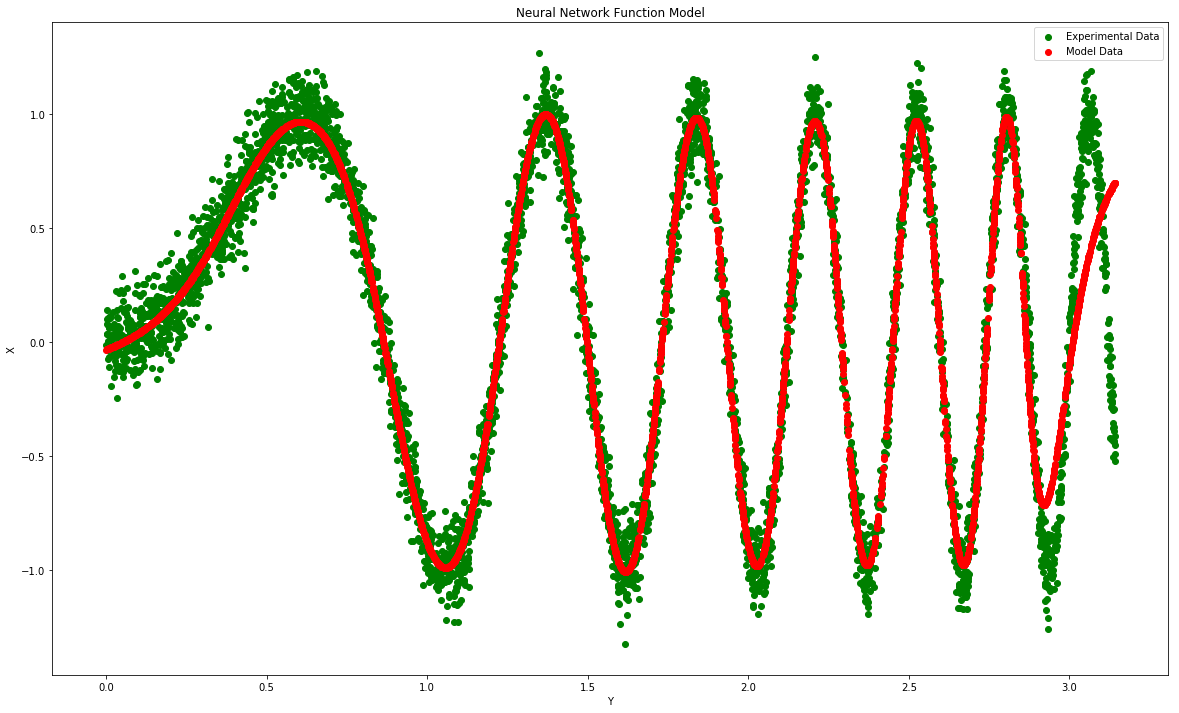

In [40]:
fig = plt.figure(figsize=(20,12))
plt.title('Neural Network Function Model')
plt.xlabel('Y')
plt.ylabel('X')
plt.scatter( all_x, f(all_x), color='g', label='Experimental Data')
plt.scatter( all_x, sess.run(output, feed_dict={X: all_x}), color='r', label='Model Data')
plt.legend()

plt.show()

### Conclusion


This model is able to fit the chirp function well. The network does begin to have trouble as the frequency increases too much, as can be seen by increasing the upper value in the `all_x` generation above. This can be viewed by removing the period modifier in the original function `f(x)`.


Tensorflow is a *very* powerful tool that can be used for all kinds of different problems! Stay tuned for more blogs like this, as I work my way up to building a Deep Q-Learning agent that can play Atari games!

Thanks for Reading -
Jason Hopper
